In [1]:
import numpy as np
from numpy.linalg import norm
import pickle
import matplotlib
import matplotlib.pyplot as plt
import itertools
from scipy.stats import norm as norm_d
from scipy.stats import expon
from scipy.stats import weibull_min as weibull
from scipy.stats import burr12 as burr
from scipy.stats import randint
from scipy.stats import uniform
from scipy.optimize import minimize
import copy
import math
import time
from scipy.optimize import minimize
from scipy.sparse.linalg import svds
from scipy.linalg import svdvals
import scipy
from sklearn.datasets import load_svmlight_file
import pickle
from pathlib import Path
from functions import *
from algorithms import *
from utils import *
from tests import *

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

%matplotlib inline

# Logistic regression

## diabetes

In [2]:
%%time
dataset = "diabetes"
A, y, m, n, sparsity_A = prepare_data(dataset)
print("Number of functions: ", m, ", dimension: ", n)
L, average_L, worst_L = compute_L(dataset, A)
denseA = A.toarray()
print("Smoothness const: ", L)
print("Average smoothness const: ", average_L)
print("Worst smoothness const: ", worst_L)
print("Percentage of non-zeros: ", sparsity_A)

Number of functions:  768 , dimension:  8
Smoothness const:  8606.922539097417
Average smoothness const:  10862.250377252869
Worst smoothness const:  189988.542101
Percentage of non-zeros:  0.8758138020833334
CPU times: user 13.8 ms, sys: 0 ns, total: 13.8 ms
Wall time: 17.9 ms


### Find the solution (Run this code only once)

In [3]:
filename=dataset+"_x_init_all_ones"
x_init = np.ones(n)
l2 = 0
l1 = 0

In [4]:
%%time
param = [A, y, l2, False, l1]
res_solver = minimize(F, x_init, args = param, jac=logreg_grad_plus_lasso, 
                      method='L-BFGS-B',
                      options={'maxiter':10000, 'disp':True}, tol=1e-18)

print(res_solver.success)
print(res_solver.fun)
print(res_solver)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.43843D+02    |proj g|=  4.92930D+01

At iterate    1    f=  6.74518D+00    |proj g|=  1.08088D+01

At iterate    2    f=  6.52135D+00    |proj g|=  3.75867D+00

At iterate    3    f=  6.21867D+00    |proj g|=  7.87736D+00

At iterate    4    f=  5.97608D+00    |proj g|=  3.99011D+00

At iterate    5    f=  4.73390D+00    |proj g|=  1.00767D+01

At iterate    6    f=  3.72021D+00    |proj g|=  2.31670D+01

At iterate    7    f=  3.06560D+00    |proj g|=  2.72215D+01

At iterate    8    f=  2.53897D+00    |proj g|=  9.32007D+00

At iterate    9    f=  2.46509D+00    |proj g|=  4.95816D+00

At iterate   10    f=  2.42356D+00    |proj g|=  5.59657D+00

At iterate   11    f=  2.37656D+00    |proj g|=  3.61513D+00

At iterate   12    f=  1.83698D+00    |proj g|=  2.22544D+01

At iterate   13    f=  1.4

 This problem is unconstrained.



At iterate   71    f=  6.08503D-01    |proj g|=  5.09897D-02

At iterate   72    f=  6.08501D-01    |proj g|=  1.11721D-02

At iterate   73    f=  6.08500D-01    |proj g|=  9.36263D-03

At iterate   74    f=  6.08498D-01    |proj g|=  1.07102D-02

At iterate   75    f=  6.08498D-01    |proj g|=  5.97870D-03

At iterate   76    f=  6.08498D-01    |proj g|=  2.50224D-03

At iterate   77    f=  6.08498D-01    |proj g|=  7.92233D-04

At iterate   78    f=  6.08498D-01    |proj g|=  2.96561D-03

At iterate   79    f=  6.08498D-01    |proj g|=  9.94118D-04

At iterate   80    f=  6.08498D-01    |proj g|=  1.35186D-03

At iterate   81    f=  6.08498D-01    |proj g|=  3.80887D-03

At iterate   82    f=  6.08498D-01    |proj g|=  1.18904D-03

At iterate   83    f=  6.08498D-01    |proj g|=  2.32152D-04

At iterate   84    f=  6.08498D-01    |proj g|=  6.91323D-05

At iterate   85    f=  6.08498D-01    |proj g|=  6.50548D-05

At iterate   86    f=  6.08498D-01    |proj g|=  6.05562D-05

At iter

In [5]:
save_solution(dataset, l2, l1, np.array(res_solver.x), res_solver.fun)

### Noise distribution

In [6]:
x_star = read_solution(dataset, l2, l1)[0]
f_star = read_solution(dataset, l2, l1)[1]

In [7]:
%%time
x = deepcopy(x_star)
grad_deviations = np.array([])
full_grad = logreg_grad(x, [denseA,y,0,False])
for i in range(m):
    grad_deviations = np.append(grad_deviations, np.linalg.norm(logreg_grad(x, [denseA[[i]],y[[i]],0,False]) - full_grad))

CPU times: user 80.7 ms, sys: 92 µs, total: 80.8 ms
Wall time: 153 ms


In [8]:
mu = np.mean(grad_deviations)
sigma = np.sqrt(np.mean(grad_deviations**2 - mu))
print(mu)
print(sigma)

81.47200713814136
98.54394276998947


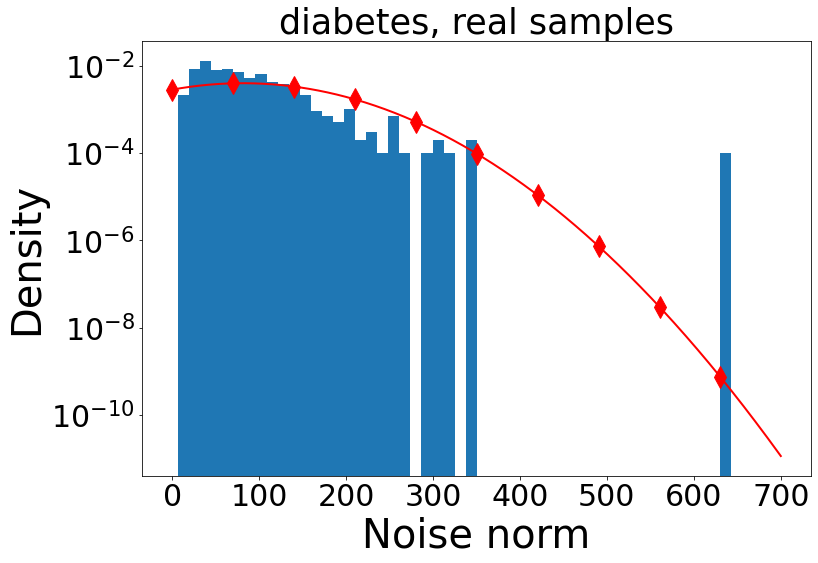

In [9]:
plt.figure(figsize=(12,8))
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
t, bins, patches = plt.hist(np.sort(grad_deviations), bins=50, density=1, log=True)
temp2 = np.linspace(0, 700, 1000)
plt.semilogy(temp2, norm_d.pdf(temp2, mu, sigma), linewidth=2, color='red', marker='d',
            markersize = 15, 
            markevery=range(0, 1000, 100))
plt.title('diabetes, real samples', fontsize=35)
plt.xlabel("Noise norm", fontsize=40)
plt.ylabel("Density", fontsize=40)
plt.savefig("plot/diabetes_real.pdf", bbox_inches='tight')

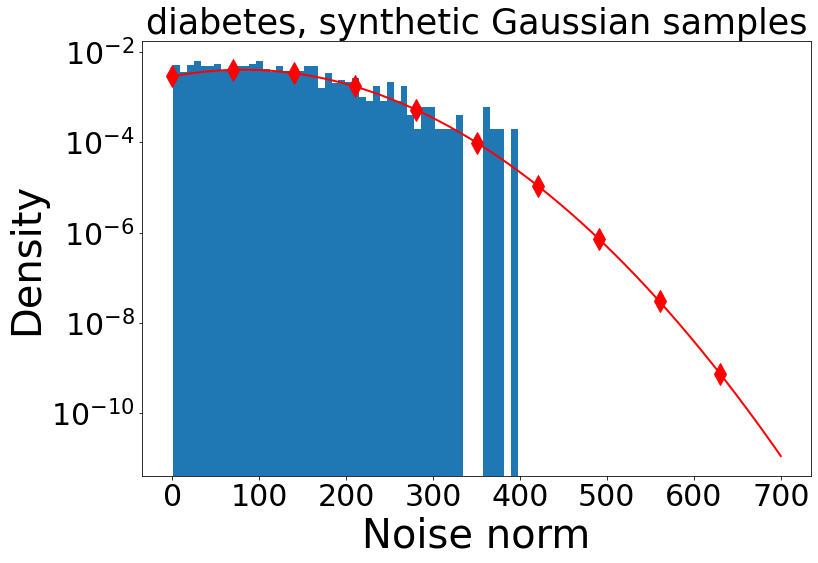

In [10]:
plt.figure(figsize=(12,8))
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
sample = norm_d.rvs(loc=mu, scale=sigma, size=m)
sample = sample[sample > 0]
t, bins, patches = plt.hist(sample, bins=50, density=(1 - norm_d.cdf(0,loc=mu,scale=sigma)), log=True)
temp2 = np.linspace(0, 700, 1000)
plt.semilogy(temp2, norm_d.pdf(temp2, mu, sigma), linewidth=2, color='red', marker='d',
            markersize = 15, 
            markevery=range(0, 1000, 100))
plt.title('diabetes, synthetic Gaussian samples', fontsize=35)
plt.xlabel("Noise norm", fontsize=40)
plt.ylabel("Density", fontsize=40)
plt.savefig("plot/diabetes_synthetic.pdf", bbox_inches='tight')

### Tests

In [11]:
shift_param = 0.1
filename=dataset+"_x_star_shifted_by_all_ones_shift_"+str(shift_param)
l2 = 0
l1 = 0
batch_size = 100
M = int(2*m/batch_size)
gamma = 1.0/(L+l2)*0.1
x_star = read_solution(dataset, l2, l1)[0]
f_star = read_solution(dataset, l2, l1)[1]
x_init = x_star + shift_param*np.ones(n)
lambd = 2*np.sqrt(2)*(L+l2)*norm(x_star-x_init)*0.01
lambd_schedule = [lambd, 1000, 0.7]
S = 10000
save_info_period = 100
beta = 0.001
N = int(S*m/batch_size)
a = ((np.log(4*N/beta)) ** 2)
print("a = ", a)

B = norm(x_star-x_init) / (np.log(4*N/beta))
print("B = ", B)

sparse_full = False
sparse_stoch = False

a =  381.9292226324597
B =  0.014472832938922759


In [12]:
print("gamma = ", gamma)

gamma =  1.1618554662917499e-05


In [13]:
print("Initial value: ", logreg_loss(x_init, [denseA,y,l2,False,0]))

Initial value:  14.45049473016926


In [14]:
print(lambd)

68.85538031277936


### SSTM

In [15]:
%%time

res = sstm(filename=filename, x_init=x_init, A=A, y=y, a=5000.0,
             L=L+l2, l2=l2, 
             sparse_full=sparse_full, sparse_stoch=sparse_stoch, 
             S=S, max_t=np.inf,
             batch_size=batch_size, indices=None, save_info_period=save_info_period, 
             x_star=x_star, f_star=f_star)

CPU times: user 10.3 s, sys: 52.4 ms, total: 10.4 s
Wall time: 12.3 s


In [16]:
%%time

res = clipped_sstm(filename=filename, x_init=x_init, A=A, y=y, a=5000,
             B=B*0.05, L=L+l2, l2=l2, 
             sparse_full=sparse_full, sparse_stoch=sparse_stoch, 
             S=S, max_t=np.inf,
             batch_size=batch_size, indices=None, save_info_period=save_info_period, 
             x_star=x_star, f_star=f_star)
#i += 1
#print("Value: ", res['func_vals'][-1]+f_star)

CPU times: user 12 s, sys: 43.1 ms, total: 12 s
Wall time: 13.2 s


### SGD and clipped-SGD

In [17]:
%%time
res = clipped_sgd_const_stepsize_decr_clip(filename=filename, x_init=x_init, A=A, y=y, gamma=gamma,
     lambd_schedule=lambd_schedule, l2=l2, 
     sparse_full=sparse_full, sparse_stoch=sparse_stoch, 
     l1=l1, S=S, max_t=np.inf,
     batch_size=batch_size, indices=None, save_info_period=save_info_period, 
     x_star=x_star, f_star=f_star)
#print("Value: ", res['func_vals'][-1]+f_star)

CPU times: user 11 s, sys: 30.4 ms, total: 11 s
Wall time: 12 s


In [18]:
%%time
res = clipped_sgd_const_stepsize(filename=filename, x_init=x_init, A=A, y=y, gamma=gamma,
     lambd=lambd*0.01, l2=l2, 
     sparse_full=sparse_full, sparse_stoch=sparse_stoch, 
     l1=l1, S=S, max_t=np.inf,
     batch_size=batch_size, indices=None, save_info_period=save_info_period, 
     x_star=x_star, f_star=f_star)
#print("Value: ", res['func_vals'][-1]+f_star)

CPU times: user 10.3 s, sys: 19.8 ms, total: 10.3 s
Wall time: 10.8 s


In [19]:
%%time
res = sgd_const_stepsize(filename=filename, x_init=x_init, A=A, y=y, gamma=gamma,
     l2=l2, 
     sparse_full=sparse_full, sparse_stoch=sparse_stoch, 
     l1=l1, S=S, max_t=np.inf,
     batch_size=batch_size, indices=None, save_info_period=save_info_period, 
     x_star=x_star, f_star=f_star)
#print("Value: ", res['func_vals'][-1]+f_star)

CPU times: user 8.33 s, sys: 5.28 ms, total: 8.33 s
Wall time: 8.53 s


FileNotFoundError: [Errno 2] No such file or directory: 'dump/diabetes_x_star_shifted_by_all_ones_shift_0.1_clipped-SGD_const_stepsize_gamma_1.1618554662917499e-05_lambda_68.85538031277936_l2_0_l1_0_num_of_epochs_10000_batch_size_100.txt'

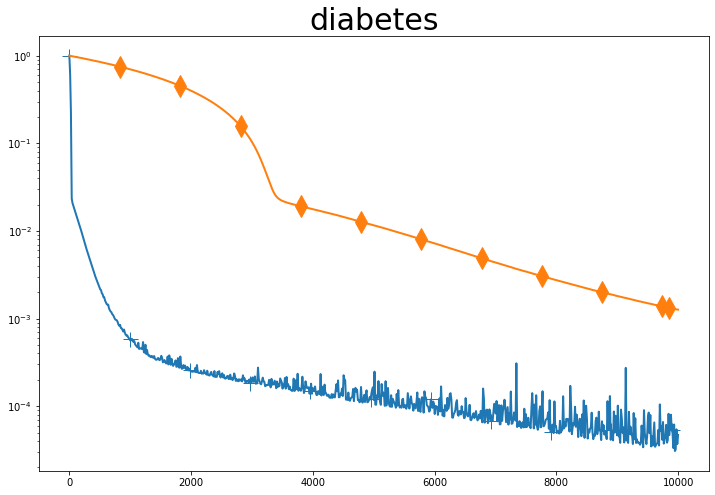

In [20]:
methods = [
             ['SGD_const_stepsize', [gamma, l2, l1, S, batch_size], 
           'SGD', None],
         ['clipped-SGD_const_stepsize', [gamma, lambd*0.01, l2, l1, S, batch_size], 
           'clipped-SGD', None],
         ['clipped-SGD_const_stepsize', [gamma, lambd, l2, l1, S, batch_size], 
           'clipped-SGD', None],
         ['clipped-SGD_const_stepsize_decr_clip', [gamma, lambd_schedule, l2, l1, S, batch_size], 
           'd-clipped-SGD', None],
           ['clipped-SSTM', [5000.0, B*0.05, L+l2, l2, S, batch_size], 
           'clipped-SSTM', None],
           ['SSTM', [5000.0, L+l2, l2, S, batch_size], 
           'SSTM', None],

]
mode_y = 'func_vals'
mode_x = 'data_passes'
figsize = (12, 8)
title_size = 30
linewidth = 2
markersize = 15
legend_size = 25
xlabel_size = 30
ylabel_size = 40
xticks_size = 20
yticks_size = 30
sizes = [title_size, linewidth, markersize, legend_size, xlabel_size, ylabel_size, xticks_size, yticks_size]
title = dataset
bbox_to_anchor = (1,1)
legend_loc="upper right"


save_fig = [True, filename+"_test.pdf"]

args_for_plots = [filename, mode_y, mode_x, figsize, sizes, title, methods, bbox_to_anchor, legend_loc, save_fig]
make_plots(args_for_plots)

In [21]:
res = read_results_from_file(filename, 'SGD_const_stepsize', [gamma, l2, l1, S, batch_size])

In [22]:
%%time
x = deepcopy(res['last_iter'])
grad_deviations = np.array([])
full_grad = logreg_grad(x, [denseA,y,0,False])
for i in range(m):
    grad_deviations = np.append(grad_deviations, np.linalg.norm(logreg_grad(x, [denseA[[i]],y[[i]],0,False]) - full_grad))

CPU times: user 45.8 ms, sys: 7.76 ms, total: 53.6 ms
Wall time: 66.9 ms


In [23]:
mu = np.mean(grad_deviations)
sigma = np.sqrt(np.mean(grad_deviations**2 - mu))
print(mu)
print(sigma)

81.48848729229928
97.96560017368768


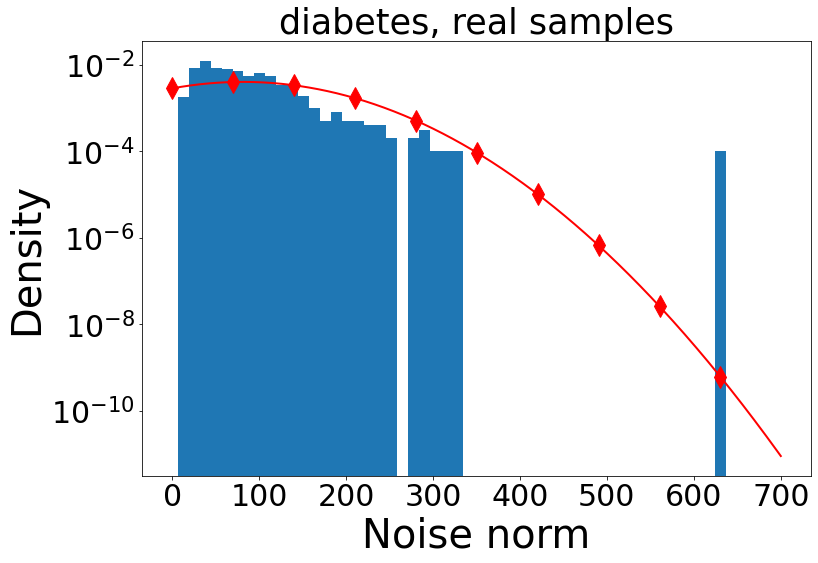

In [24]:
plt.figure(figsize=(12,8))
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
t, bins, patches = plt.hist(np.sort(grad_deviations), bins=50, density=1, log=True)
temp2 = np.linspace(0, 700, 1000)
plt.semilogy(temp2, norm_d.pdf(temp2, mu, sigma), linewidth=2, color='red', marker='d',
            markersize = 15, 
            markevery=range(0, 1000, 100))
plt.title('diabetes, real samples', fontsize=35)
plt.xlabel("Noise norm", fontsize=40)
plt.ylabel("Density", fontsize=40)
plt.savefig("plot/diabetes_sgd_last_point.pdf", bbox_inches='tight')

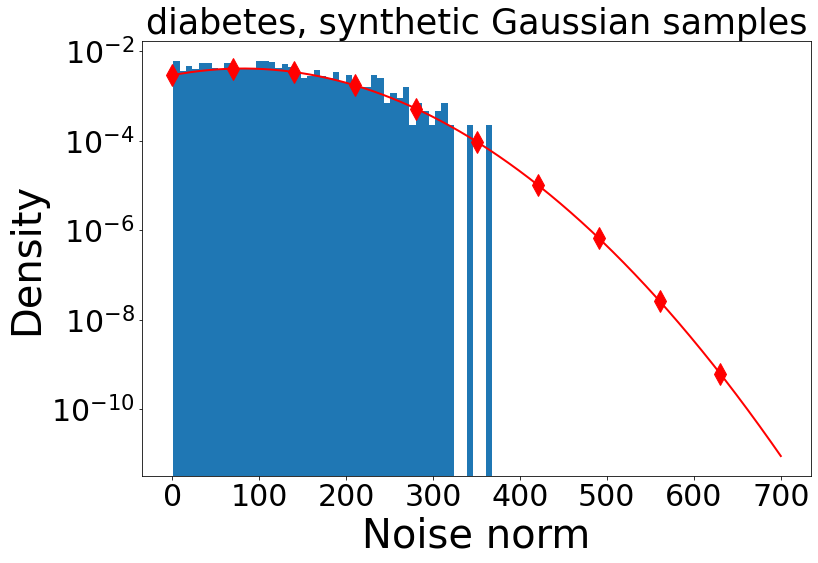

In [25]:
plt.figure(figsize=(12,8))
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
sample = norm_d.rvs(loc=mu, scale=sigma, size=m)
sample = sample[sample > 0]
t, bins, patches = plt.hist(sample, bins=50, density=(1 - norm_d.cdf(0,loc=mu,scale=sigma)), log=True)
temp2 = np.linspace(0, 700, 1000)
plt.semilogy(temp2, norm_d.pdf(temp2, mu, sigma), linewidth=2, color='red', marker='d',
            markersize = 15, 
            markevery=range(0, 1000, 100))
plt.title('diabetes, synthetic Gaussian samples', fontsize=35)
plt.xlabel("Noise norm", fontsize=40)
plt.ylabel("Density", fontsize=40)
plt.savefig("plot/diabetes_synthetic_sgd_last_iter.pdf", bbox_inches='tight')